In [1]:
import pandas as pd
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import plotly.graph_objects as go


# Predicting Genre with Song Characteristics

Let's see if we are able to predict the genres of songs in our dataset using the different audio features of tracks that were identified by Spotify, like "loudness" or "danceability."

We'll start by importing our .csv data into pandas. We can drop popularity for now, which has only been collected for a small number of our datapoints.

In [2]:
tracks = pd.read_csv('data/audio_features_4.0_clean.csv')
tracks = tracks.drop(['popularity'], axis=1)

seed = 538

For the sake of training our models, we'll start by using a smaller sub-sample of our data to allow us to rapidly test a variety of options.

In [3]:
# Prototyping sample for model selection
tracks = tracks.sample(n=25000, random_state=seed)

## Initial visualization

We'll perform some initial visualizations to get a better sense of our data.

So that we can see the coorelation with genre, we'll encode genre with label encoder.

In [4]:
# Encode genre with label encoder.
label_enc = LabelEncoder()
tracks_enc = tracks.copy(deep=True)
tracks_enc.loc[:, 'genre'] = label_enc.fit_transform(tracks.genre)

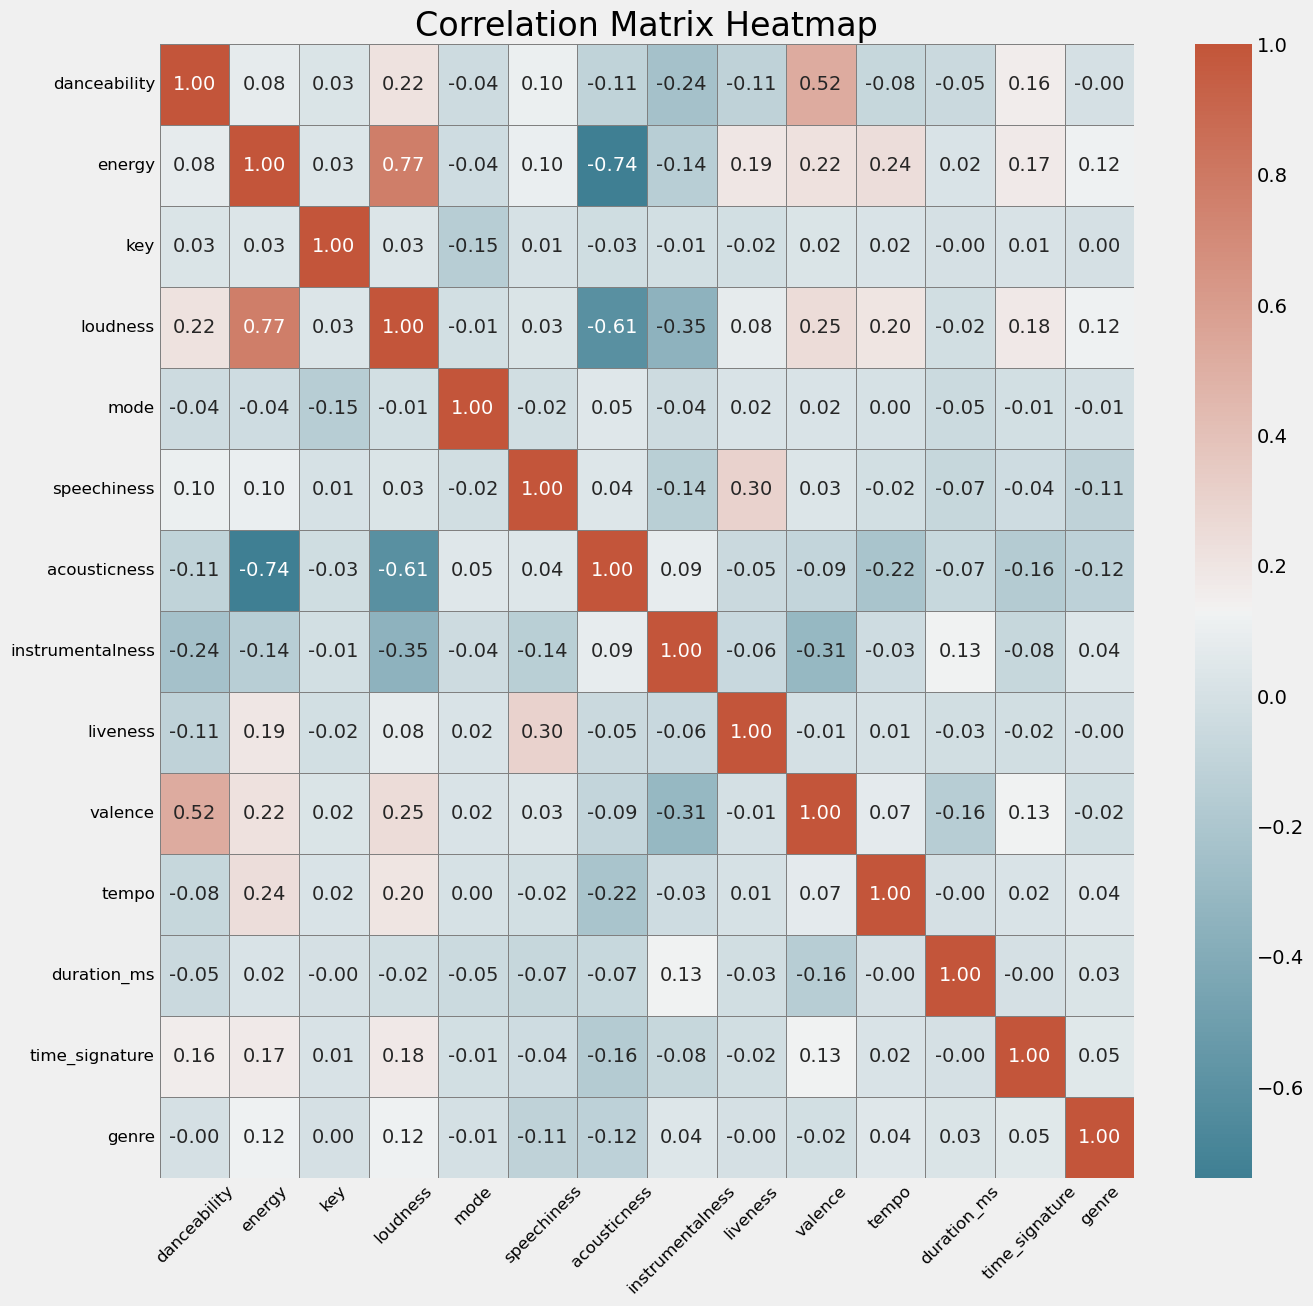

In [5]:
# Coorelation matrix heatmap.
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(14, 14))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tracks_enc.corr(), annot=True, fmt='.2f', cmap=cmap, linewidths=0.5, linecolor='gray')
plt.title("Correlation Matrix Heatmap", fontsize=24)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Overall, there is high colinearity between some features (like loudness and energy), but only a moderate relationship between our different predictors and genre. This will make our classification task more difficult.

Let's also check the distribution of our features.

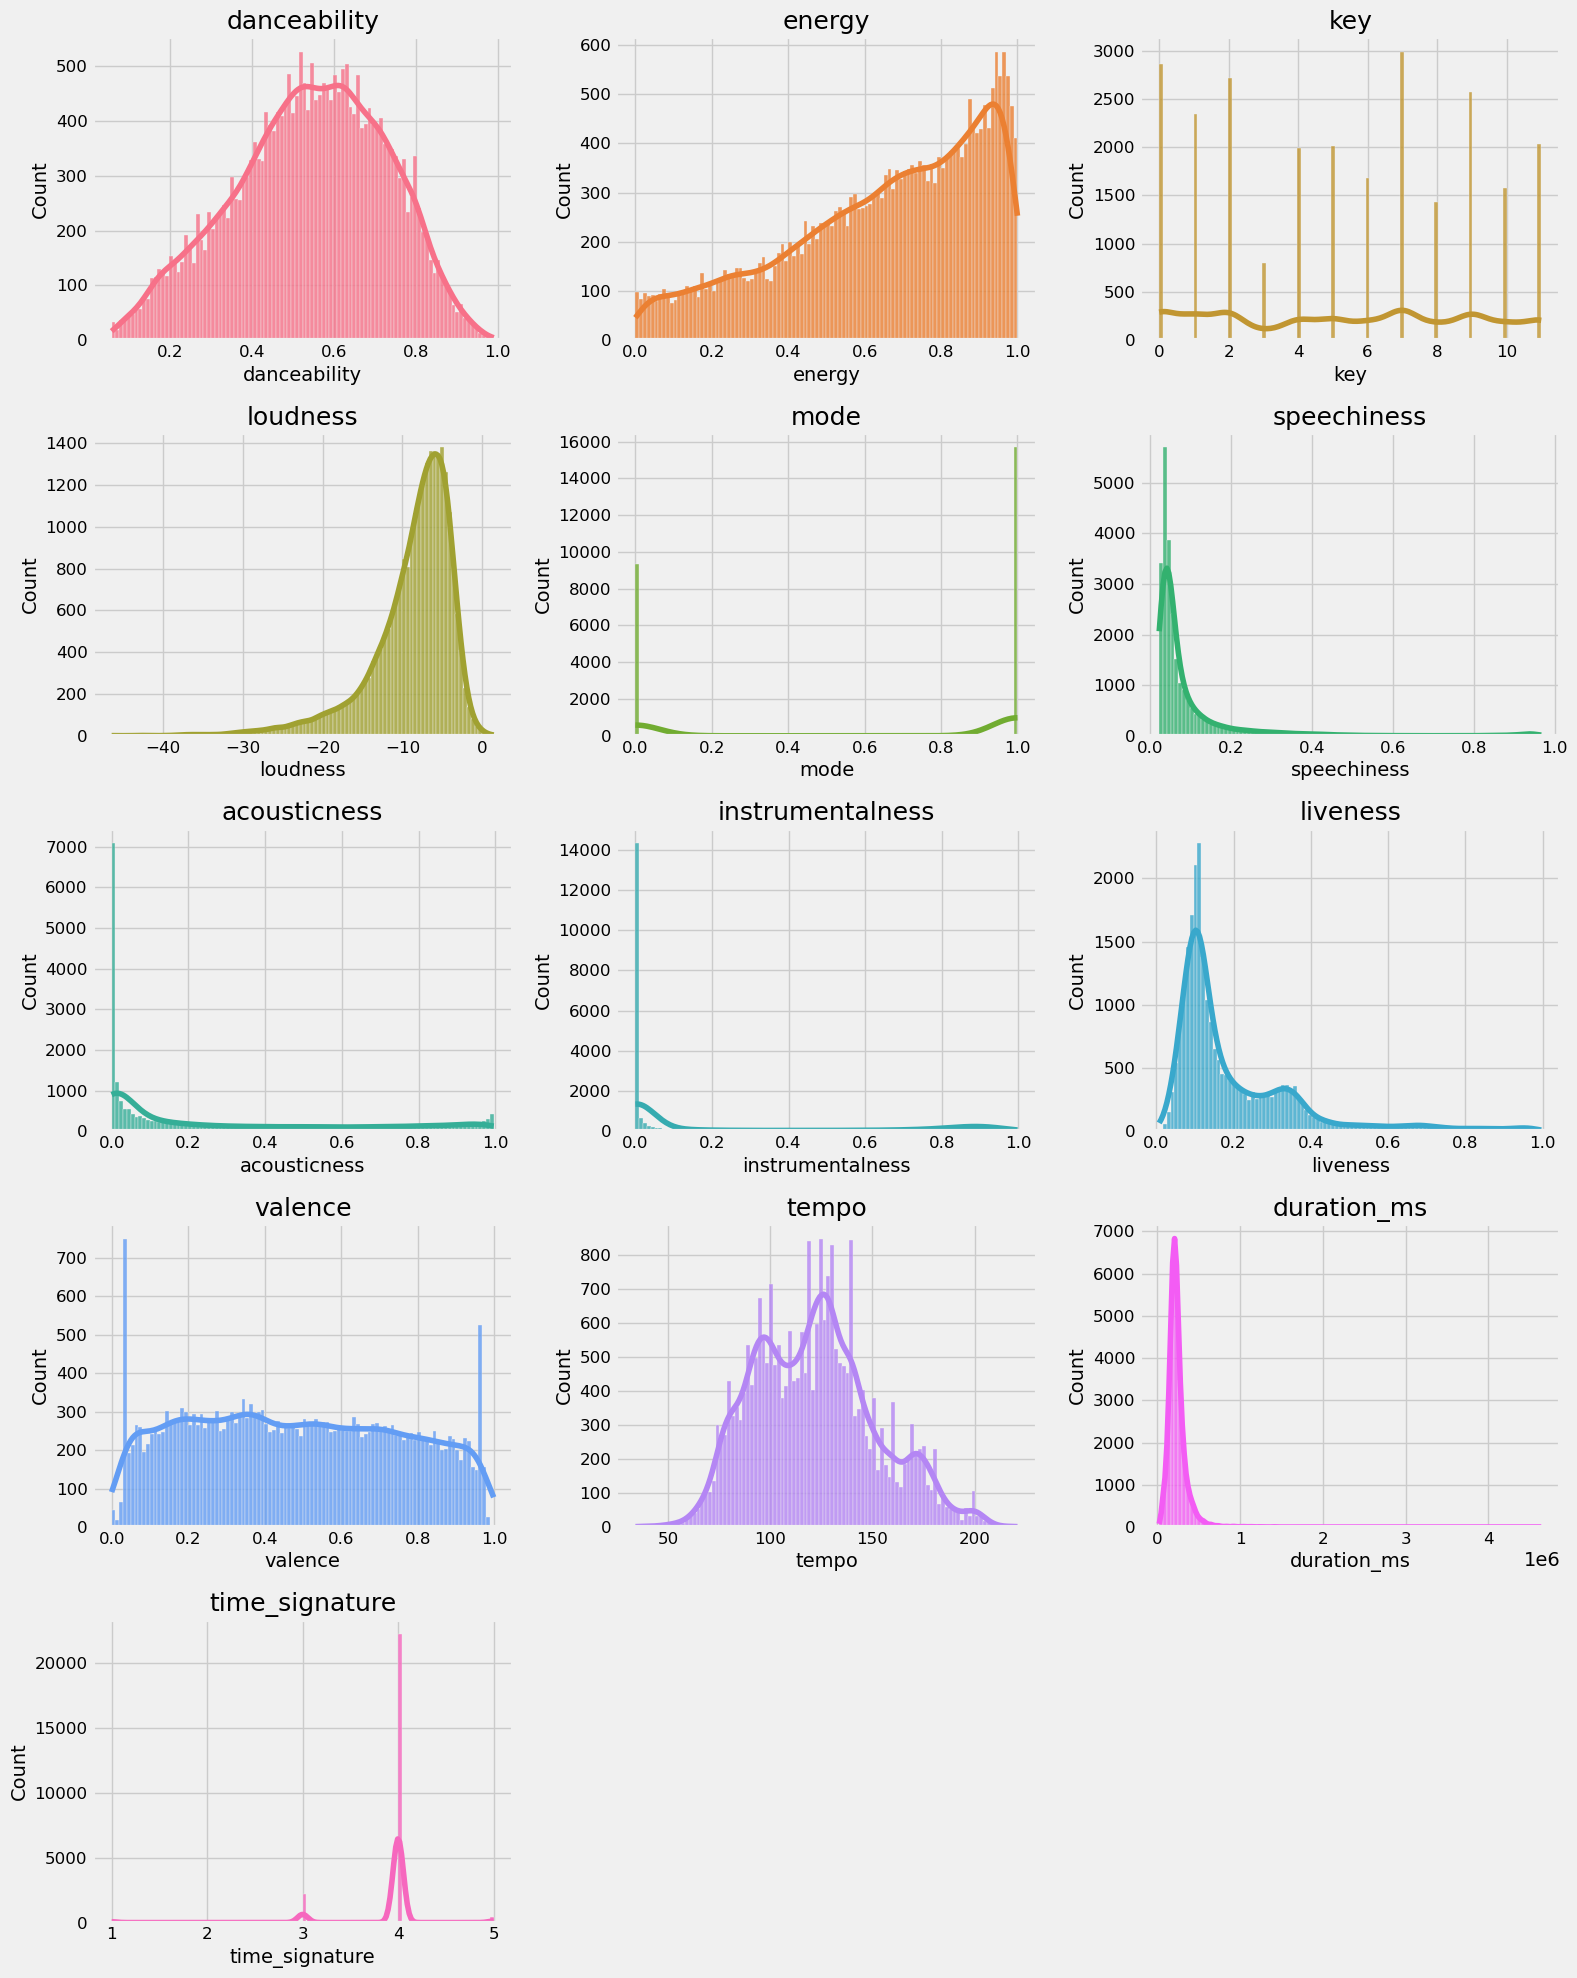

In [6]:
cols = tracks.select_dtypes(include={'int64', 'float64'}).columns
ncols = 3

nrows = (len(cols) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, 
                         ncols=ncols, 
                         figsize=(16, 4 * nrows), 
                         sharey=False)
axes = axes.flatten()

# Set the color palette for the histograms
colors = sns.color_palette('husl', len(cols))

for i, col in enumerate(cols):
    sns.histplot(tracks, x=col, bins=100, ax=axes[i], color=colors[i], kde=True, alpha=0.8)
    axes[i].set_title(col, fontsize=18)
    axes[i].set_xlabel(col, fontsize=14)
    axes[i].set_ylabel('Count', fontsize=14)
    axes[i].tick_params(axis='both', labelsize=12)

for i in range(len(cols), nrows * ncols):
    fig.delaxes(axes[i])

fig.tight_layout()
plt.show()

Based on these plots, we can see that energy, loudness, and liveness are moderately skewed. Speechiness, acousticness, and instrumentalness are even more skewed. Valence is roughly uniformly distributed, with some clustering at both extremes.

Because some of our features are skewed and not normally-distributed, we'll have to use techniques that are robust to these distributions. Furthermore, we should keep in mind that, as we established in the previous data cleaning notebook, some of our features have significant numbers of outliers.

Let's also look at class imbalance, which is another important consideration when modeling.

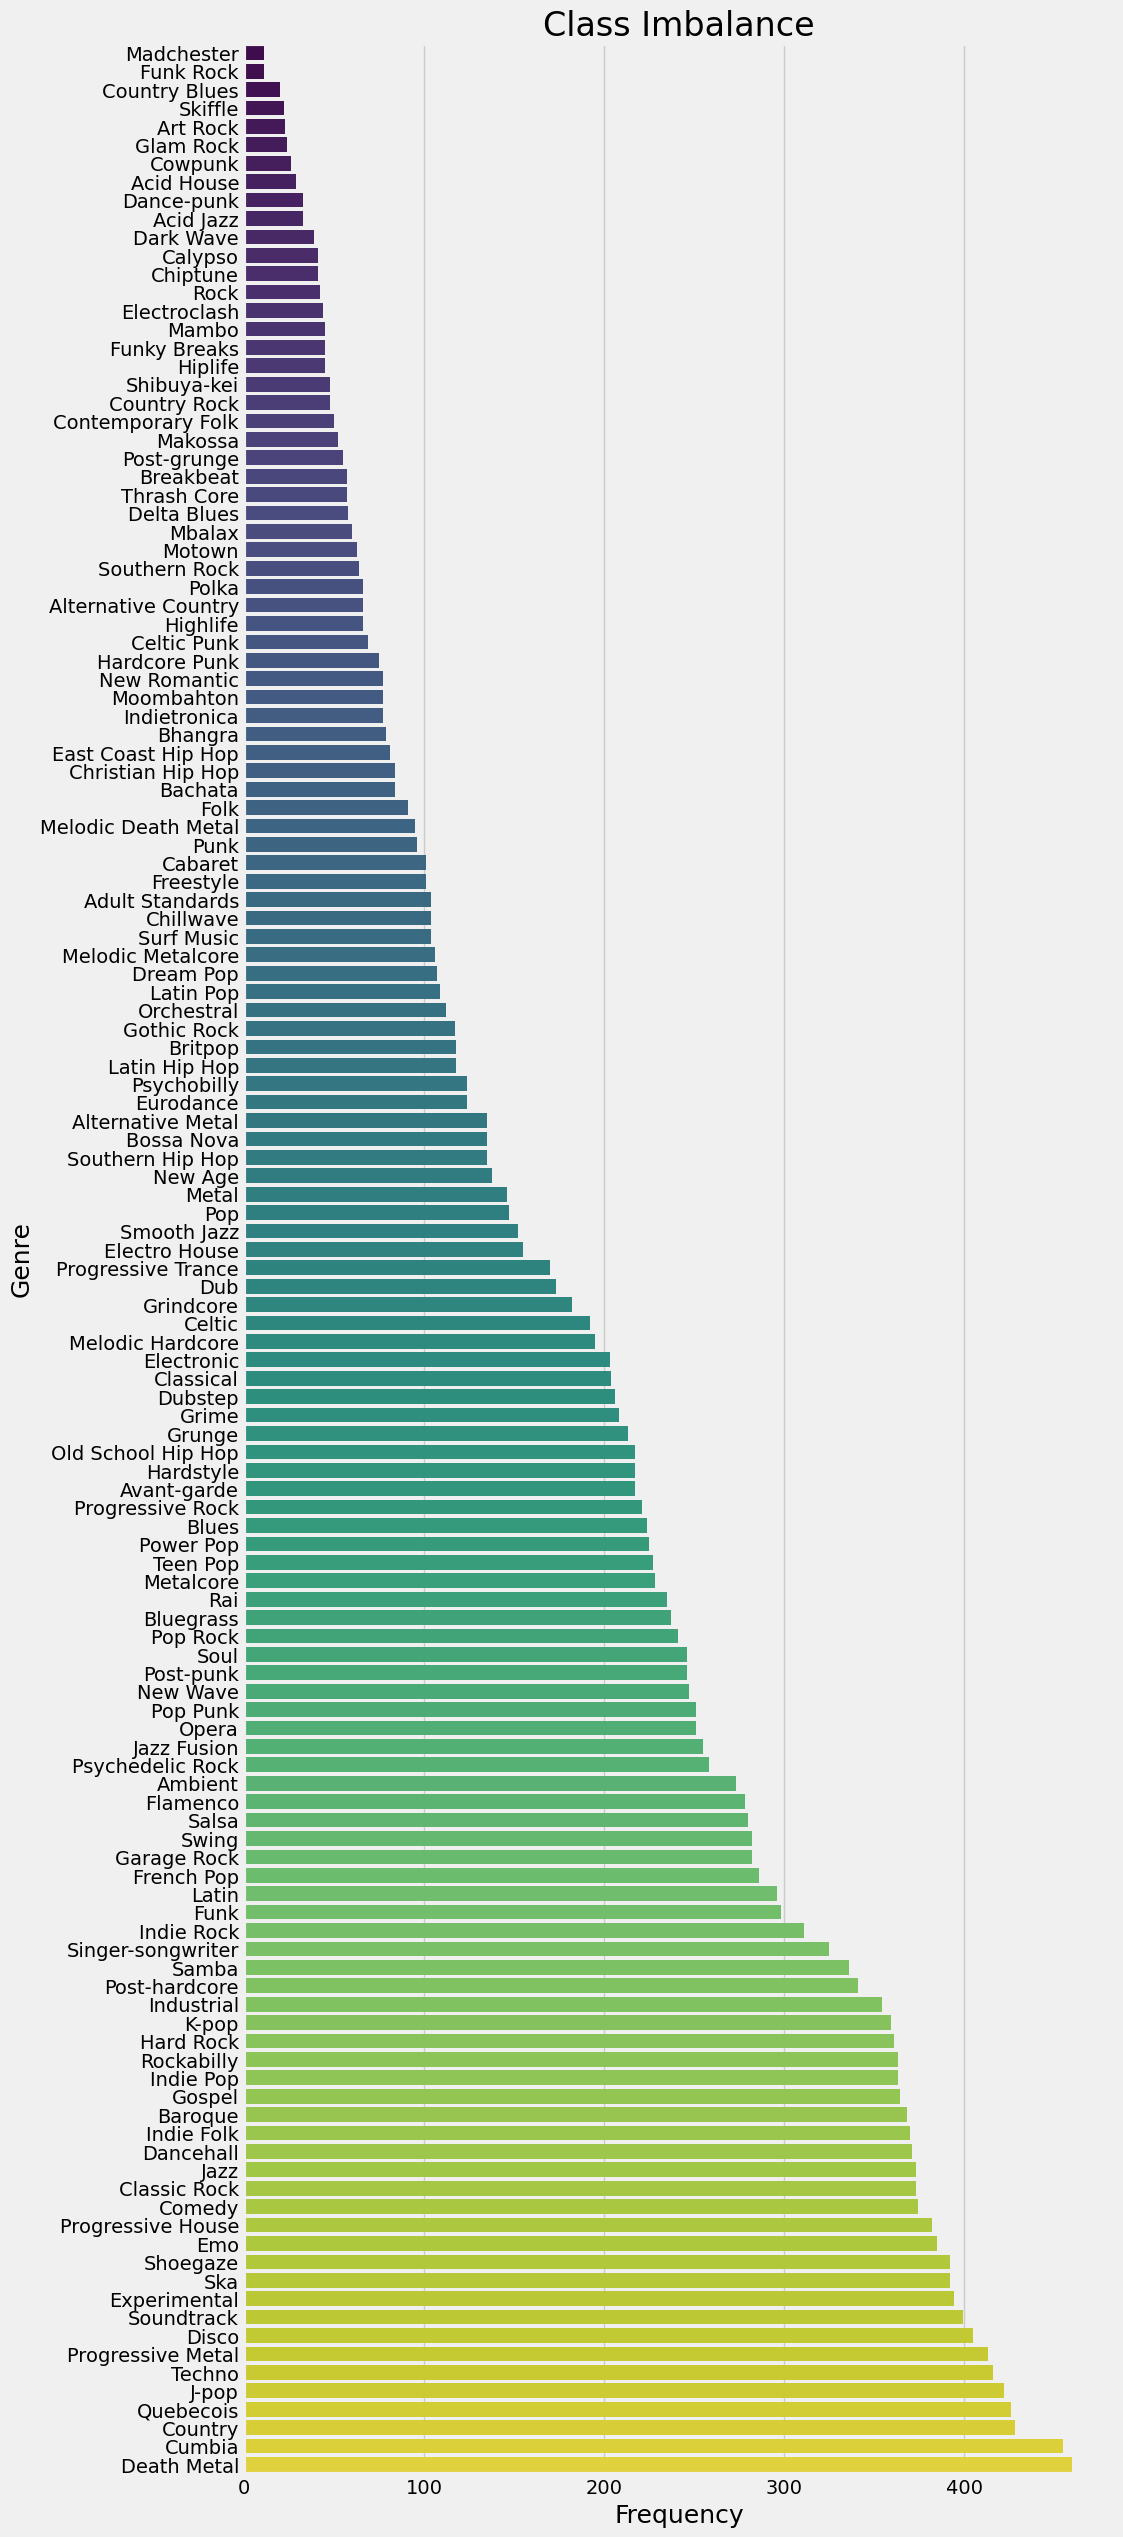

In [7]:
class_counts = tracks['genre'].value_counts()\
                            .sort_values(ascending=True)

plt.figure(figsize=(10, 30))
color_palette = sns.color_palette("viridis", 
                                  n_colors=len(class_counts))
sns.barplot(x=class_counts.values,
            y=class_counts.index,
            orient='h',
            palette=color_palette)
plt.xlabel('Frequency', fontsize=18)
plt.ylabel('Genre', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Class Imbalance', fontsize=24)

plt.show()

## Class balancing, scaling, and train-test split

Let's split our data into train and test so we can start building an initial classification model as a baseline.

For our initial model, we'll drop non-numeric features.

In [8]:
# Drop genre, our target, as well as the columns with text data 
# and the Spotify track id.
X = tracks.drop(['genre',
                 'song_name',
                 'artist_name',
                 'spotify_track_id'], axis=1)
y = tracks.genre

genre_encoder = LabelEncoder()
y = genre_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.3, 
                                                    random_state=seed)

 Now, we will use SMOTE over-sampling to randomly generate new datapoints for the remaining under-represented classes, with the new random points being based on the existing data in those classes.

In [9]:
over_sampler = SMOTE()
X_train_smote, y_train_smote = over_sampler.fit_resample(X_train, y_train)

## Initial modeling

Let's start with K-Nearest Neighbors as a baseline to see what kind of accuracy we can achieve.

We found a high number of outliers in our previous data cleaning analysis, which seem simply to be extreme values rather than bad data. Some of the features are also highly skewed.

To help mitigate these complexities we will start with RobustScaler, which is good at handling outliers and skew. If our features had very different scales RobustScaler might not perform well, but in our case the values are mostly close, with the exception of duration_ms, so it seems like a reasonable choice.

In [10]:
scaler = RobustScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

To get a baseline, we'll train a K-Nearest Neighbors classifier.

In [11]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_smote_scaled, y_train_smote)
knn_model.score(X_test_scaled, y_test)

0.0836

An accuracy of only 14% tells us that we have a lot of work to do. Before we test additional models and hyperparameters, let's see if the high number of classes in our dataset (over 100 genres) and the class imbalance is impacting performance, and whether that issue can be mitigated.

## Classification with alternative scoring

One reason why it might be difficult to classify genres accurately is that there are some very similar genres in our dataset. For example, we have many different sub-genres of Hip Hop, rock, etc. 

One way we can address this is to relax the rules for classification, so that it counts as an accurate prediction if any of the top three options identified by the model are the correct genre. 

We can implement this with a custom scoring function. We'll also create a version that scores the top 2 and 4 results so we can compare.

In [12]:
def top_3_accuracy(y_true, y_pred_proba):
    top_classes = np.argsort(y_pred_proba, axis=1)[:, -3:]
    matches = [y_true[i] in top_classes[i] for i in range(len(y_true))]
    return np.mean(matches)

def top_2_accuracy(y_true, y_pred_proba):
    top_classes = np.argsort(y_pred_proba, axis=1)[:, -2:]
    matches = [y_true[i] in top_classes[i] for i in range(len(y_true))]
    return np.mean(matches)

def top_4_accuracy(y_true, y_pred_proba):
    top_classes = np.argsort(y_pred_proba, axis=1)[:, -4:]
    matches = [y_true[i] in top_classes[i] for i in range(len(y_true))]
    return np.mean(matches)

top_3_scorer = make_scorer(top_3_accuracy, needs_proba=True)

Let's go back to KNN, and see what result we get with our custom scorer.

In [13]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_smote_scaled, y_train_smote)
y_pred_proba = knn_model.predict_proba(X_test_scaled)

print('Top 2:', top_2_accuracy(y_test, y_pred_proba))
print('Top 3:', top_3_accuracy(y_test, y_pred_proba))
print('Top 4:', top_4_accuracy(y_test, y_pred_proba))

Top 2: 0.1456
Top 3: 0.18946666666666667
Top 4: 0.21653333333333333


The lower bar for classification success has improved our results somewhat. Now let's go through and test a variety of models to see what level of success we can achieve.

## K-Nearest Neighbors Classifier

Let's try out a variety of k values, performing 5-fold cross-validation on each to find the best result.

In [14]:
k_values = list(range(2, 21))
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, 
                            X_train_smote_scaled, 
                            y_train_smote, 
                            scoring=top_3_scorer, 
                            cv=5) \
                            .mean()
    scores.append(score)

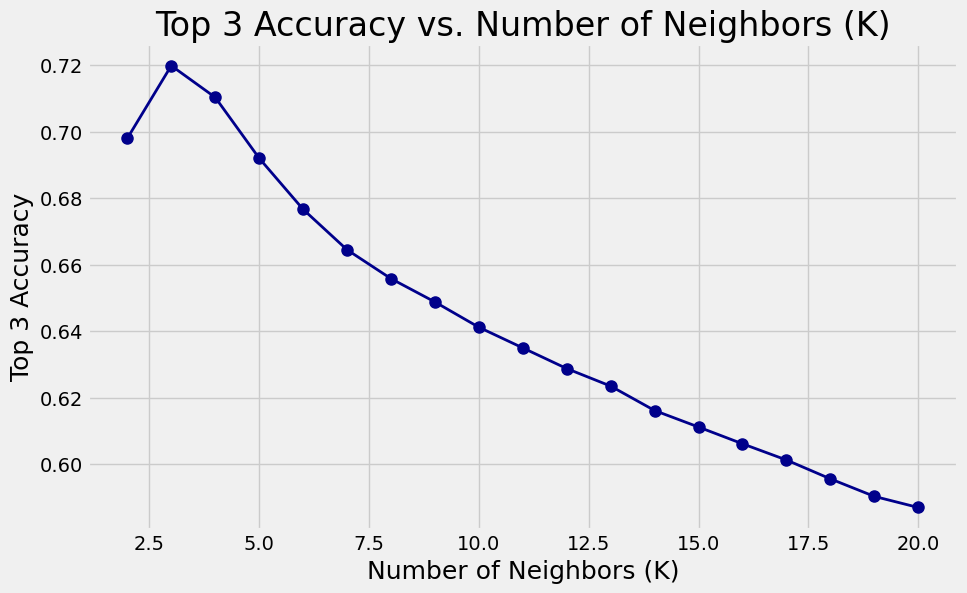

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, color='darkblue', marker='o', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Neighbors (K)', fontsize=18)
plt.ylabel('Top 3 Accuracy', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Top 3 Accuracy vs. Number of Neighbors (K)', fontsize=24)
plt.show()

Overall, it seems that performance drops rapidly with higher values of k.

In [16]:
# Get the index of the best score and lookup the best k.
best_k = k_values[np.argmax(scores)]
best_score = np.max(scores)

knn_best_k = KNeighborsClassifier(n_neighbors=best_k)
knn_best_k.fit(X_train_smote_scaled, y_train_smote)
y_pred_proba = knn_best_k.predict_proba(X_test_scaled)

print('Top 2:', top_2_accuracy(y_test, y_pred_proba))
print('Top 3:', top_3_accuracy(y_test, y_pred_proba))
print('Top 4:', top_4_accuracy(y_test, y_pred_proba))

Top 2: 0.13973333333333332
Top 3: 0.16773333333333335
Top 4: 0.17213333333333333


This result indicates that KNN is likely not the best approach. Not only does the value for k obtained through cross-validation result in a slightly worse score than the default value of 5, but also there is a huge discreprepancy between train and test, which likely means we are overfitting.

## Logistic Regression CV

Another option we can try is logistic regression. Because this method applies a regularization penatly to the different features in our dataset, it is useful for addressing colinearity between predictors. This is good in our case, because our features are mostly coorelated more strongly with each other than they are with our target (genre). 

We can reduce some of this noise by applying a disproportionate penalty to the largest coefficients (i.e. applying regulariazation). The LogisticRegressionCV class is particularly useful, because it uses K-Fold cross validation to test a variety of possible regularization penalty strenghts and selects the one that achieves the best results. 

In [17]:
regressor = LogisticRegressionCV(max_iter=10000, 
                                 cv=5, 
                                 random_state=seed,
                                 scoring=top_3_scorer) \
                                .fit(X_train_smote_scaled, y_train_smote)

y_lr_probas = regressor.predict_proba(X_test_scaled)
print('Top 2:', top_2_accuracy(y_test, y_lr_probas))
print('Top 3:', top_3_accuracy(y_test, y_lr_probas))
print('Top 4:', top_4_accuracy(y_test, y_lr_probas))

Top 2: 0.20173333333333332
Top 3: 0.2624
Top 4: 0.3082666666666667


## Random Forest Classifier

Next, let's try a decision tree-based model, which works by repeatedly finding the feature that most reduces class impurity, progressively creating smaller groups until a stopping point is reached.

In this case, we'll use a random forest, which is an ensemble method that trains a series of individual decision trees. Each tree is trained on a random subset of data and features, which helps reduce overfitting and volitility created by a particular set of input data.

A common rule of thumb for setting the maximum features to consider when making splits is that it should be the square root of the number of available features, which in this case is about 4. 

We'll also try some parameters to prevent overfitting, including max_depth, which limits the height of the binary decision tree min_samples_split, which limits how many samples can be used to make a split, and n_estimators, which is the number of underlying decision trees to train

In [18]:
forest = RandomForestClassifier(random_state=seed,
                                    max_depth=100,  
                                    n_estimators=150,
                                    max_features=4
                                    ) \
                                    .fit(X_train_smote_scaled, y_train_smote)
forest_pred = forest.predict_proba(X_test_scaled)

print('Top 2:', top_2_accuracy(y_test, forest_pred))
print('Top 3:', top_3_accuracy(y_test, forest_pred))
print('Top 4:', top_4_accuracy(y_test, forest_pred))

Top 2: 0.2484
Top 3: 0.30466666666666664
Top 4: 0.35733333333333334


This method acheives slightly better results, although the prediction strength is still relatively weak. 

Our accuracy score means that the correct genre fell in the top 3 predicted genres only 30% of the time, which means that the vast majority of the time we're pretty far off the mark.

Still, we can use this modeling exercise to perform some analytics to help us understand more about the characteristics of the genres in our dataset.

## Genre Visualization

Let's start by looking at which genres were easiest and hardest for our final model (random forest) to predict.

In [19]:
class_labels = genre_encoder.inverse_transform(np.arange(len(genre_encoder.classes_)))

robust_scaler = RobustScaler()
X_scaled = robust_scaler.fit_transform(X)

# Generate predicted class labels
y_pred = forest.predict(X_scaled)

# Calculate the classification report
report = classification_report(y, y_pred)

f1_scores = f1_score(y, y_pred, average=None)
f1_scores_dict = dict(zip(class_labels, f1_scores))
sorted_f1_scores = dict(sorted(f1_scores_dict.items(), 
                                key=lambda item: item[1], 
                                reverse=True
                                ))


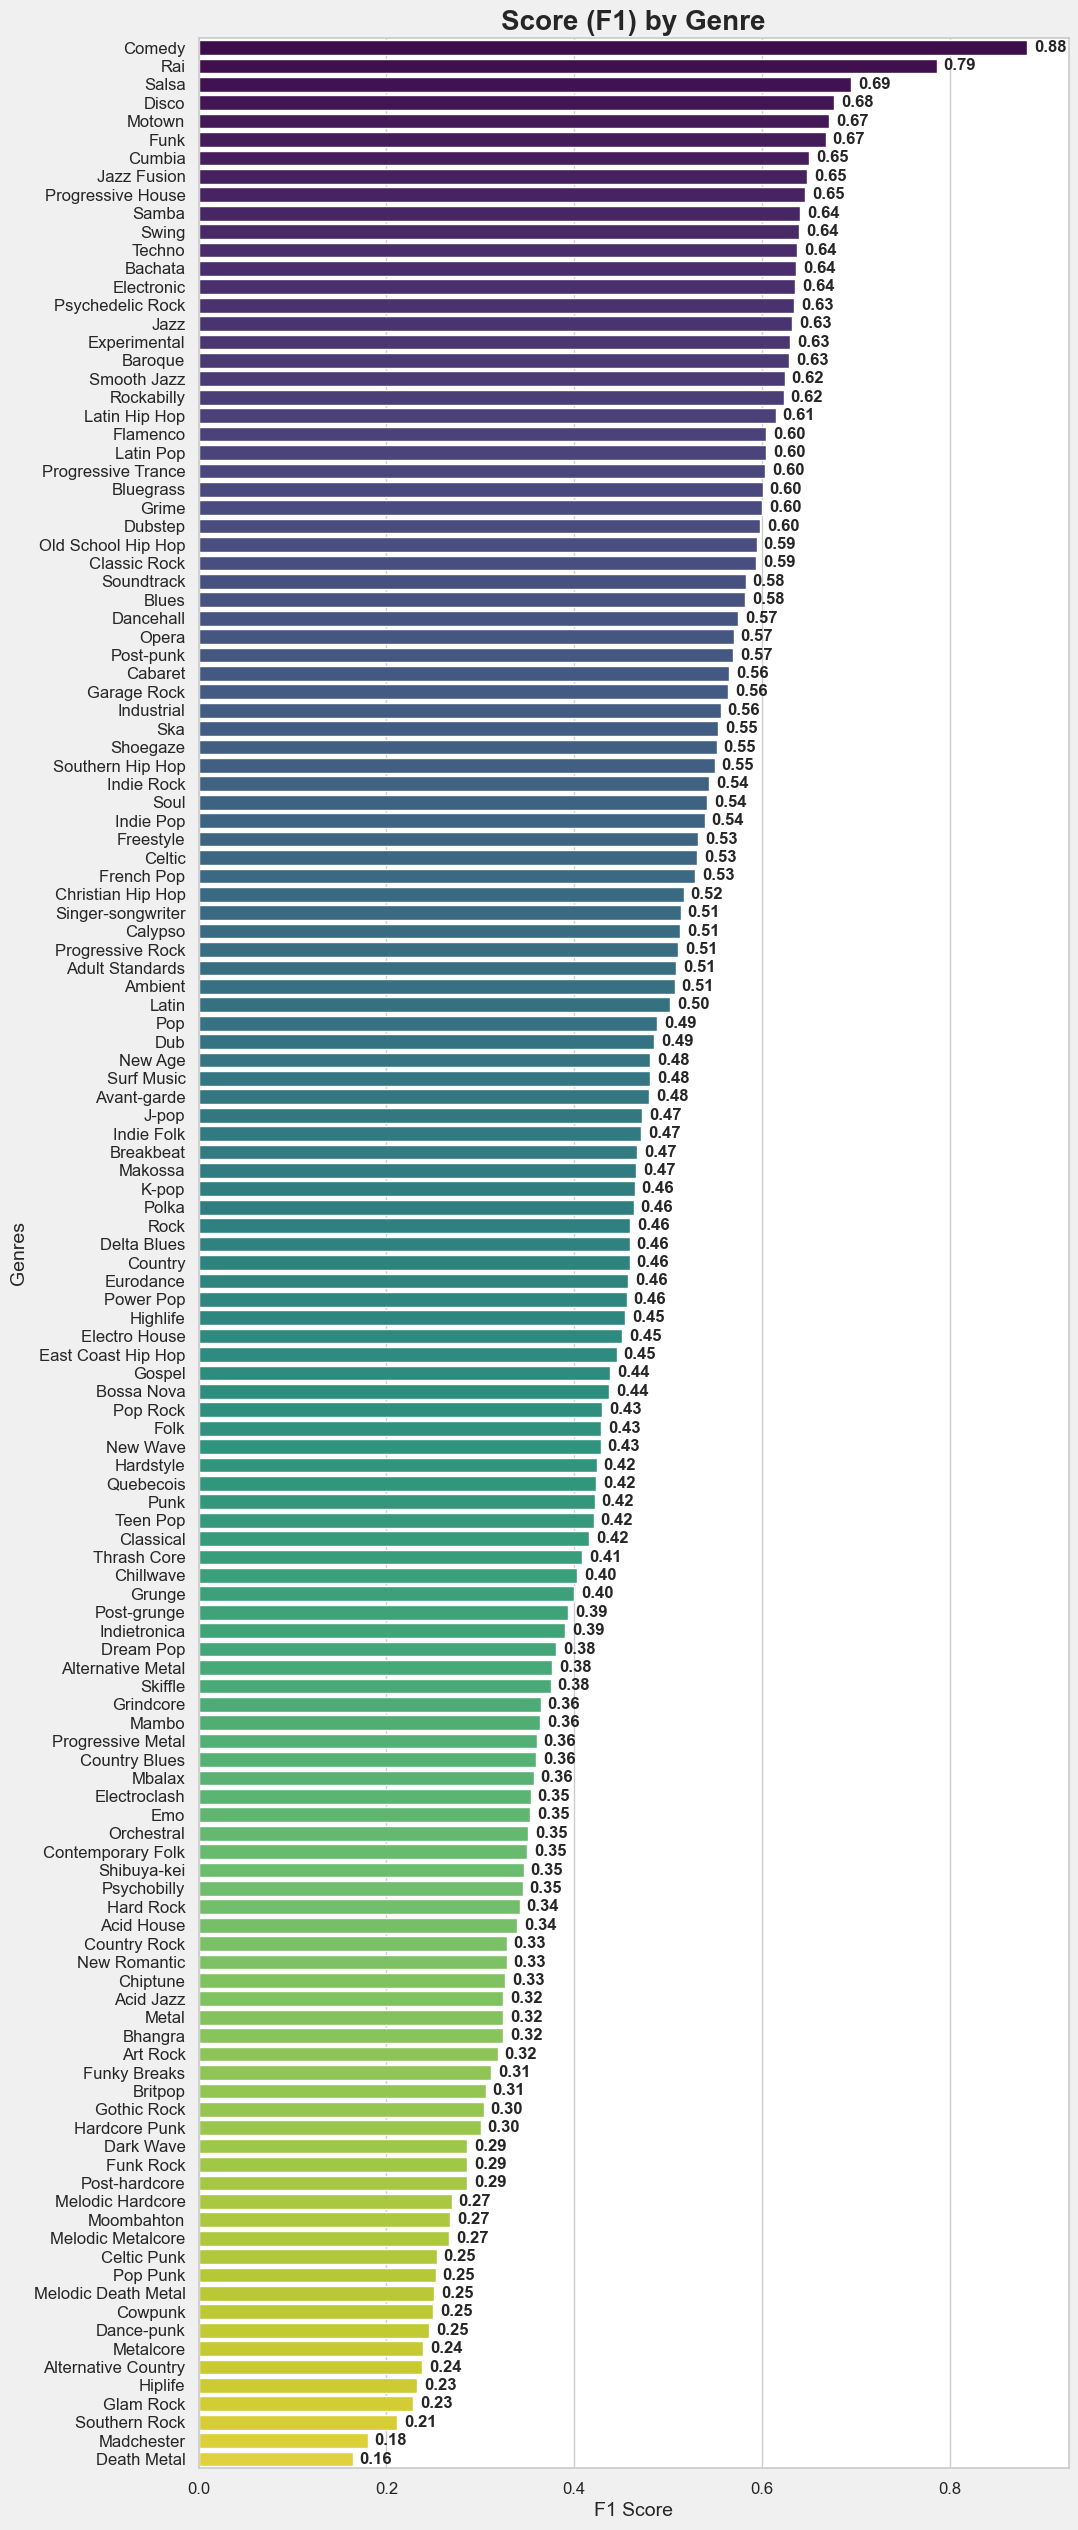

In [20]:
# Create the bar plot
plt.figure(figsize=(10, 30))
sns.set(style="whitegrid")
ax = sns.barplot(y=list(sorted_f1_scores.keys()), x=list(sorted_f1_scores.values()), palette="viridis")
ax.set_title("Score (F1) by Genre", fontsize=20, fontweight="bold")
ax.set_xlabel("F1 Score", fontsize=14)
ax.set_ylabel("Genres", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Annotate the bars with F1 scores
for p in ax.patches:
    ax.annotate("{:.2f}".format(p.get_width()),
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha="left",
                va="center",
                xytext=(5, 0),
                textcoords="offset points",
                fontsize=12,
                fontweight="bold"
                )

# Show the plot
plt.show()

Interestingly, some of the worst-performing genres seem related, with many types of heavy metal and rockrepresented. This may indicate that one difficulty for the model is distinguishing between closely-related genres.

Let's also look to see if we can see a relationship between precision and recall and the number of supporting samples for each genre in our dataset. Precision is the ratio of true positive predictions to the total positive predictions, while recall is the ratio of true positive predictions to the total actual positive instances.

In [21]:
# Compute the accuracy per class (genre)
report = classification_report(y, 
                                y_pred, 
                                output_dict=True)
precision = [report[str(i)]['precision'] for i in range(len(np.unique(y_test)))]
recall = [report[str(i)]['recall'] for i in range(len(np.unique(y_test)))]

# Count the number of samples per class in the dataset
class_counts = np.bincount(y)

# Create a DataFrame for easier plotting
data = pd.DataFrame({'Genre': range(len(np.unique(y))),
                     'Precision': precision,
                     'Recall': recall,
                     'Sample Count': class_counts})

For visualization purposes, let's pick out a few interesting genres to highlight. We'll pick a few with high f1-score, a few with a medium score, and a few with a low score. To avoid unnecessary transformations in the next step, we'll convert these values to integers using the LabelEncoder we trained at the beginning.

In [22]:
# Get labels for a few selected genres. 
viz_sample_genres = genre_encoder.transform(np.array([
        # Genres with high f1-score
        'Jazz Fusion',
        'Progressive House',

        # Genres with medium f1-score
        'K-pop',
        'Country',

        # Genres with low f1-score
        'Death Metal',
        'Acid Jazz'
]))

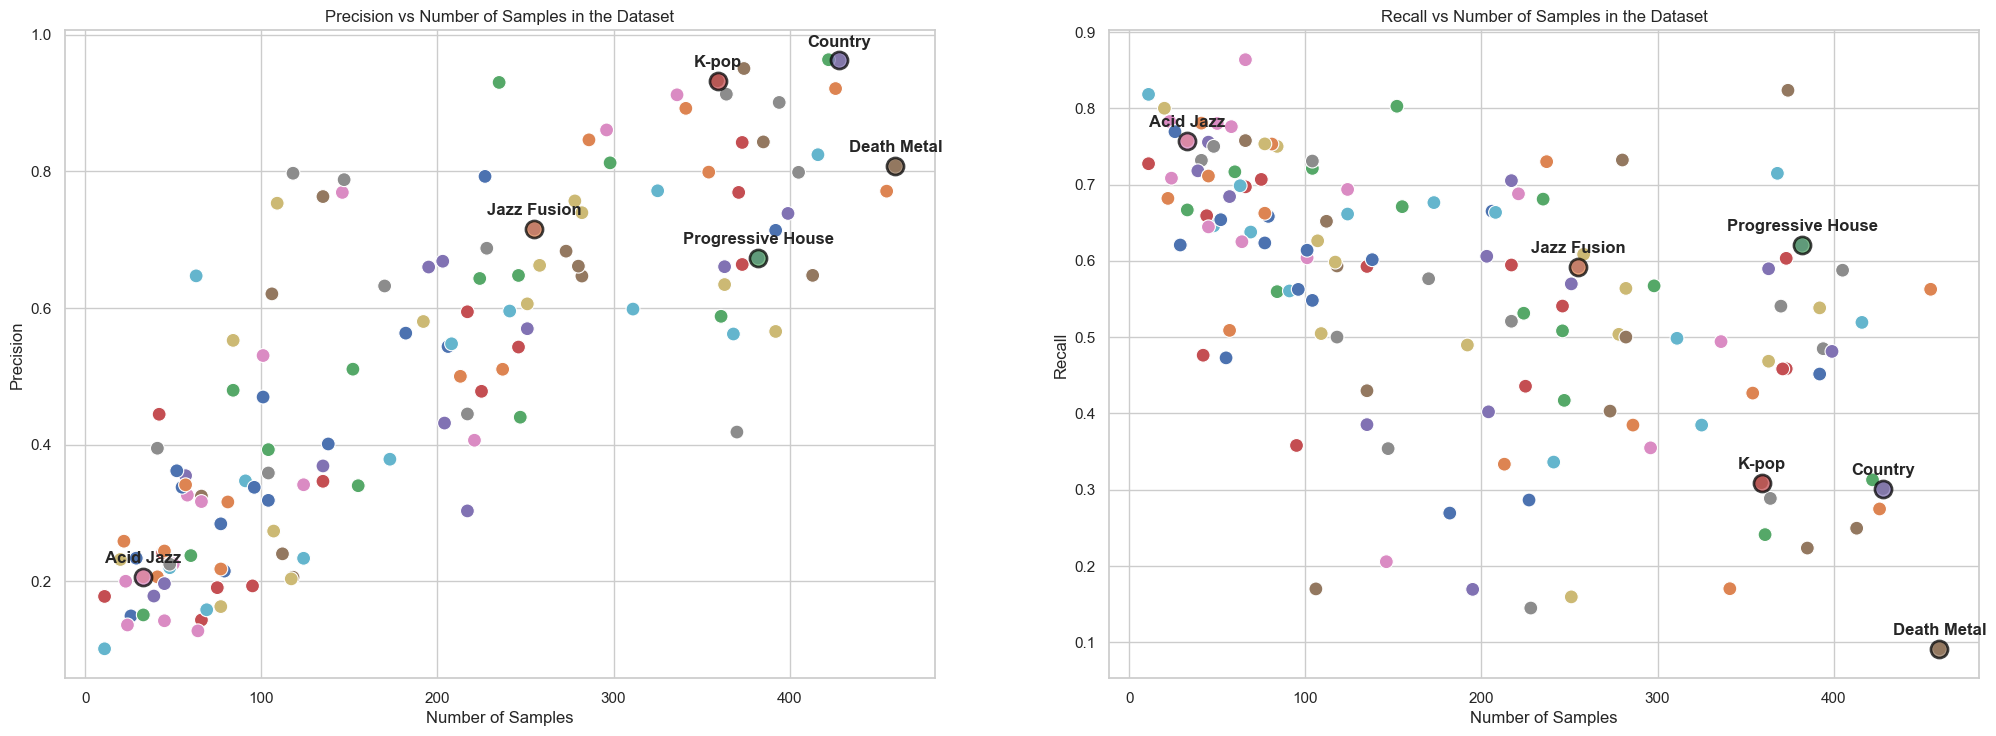

In [23]:
# Create the 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

# Create the Precision scatter plot
sns.scatterplot(ax=axes[0], 
                    data=data, 
                    x='Sample Count', 
                    y='Precision', 
                    hue='Genre', 
                    palette='deep', 
                    s=100)
axes[0].get_legend().remove()

# Create the Recall scatter plot
sns.scatterplot(ax=axes[1], 
                    data=data, 
                    x='Sample Count', 
                    y='Recall', 
                    hue='Genre', 
                    palette='deep', 
                    s=100)
axes[1].get_legend().remove()

# Add annotations and highlight selected points for both subplots
selected_genres = viz_sample_genres
for genre in selected_genres:
    genre_data = data[data['Genre'] == genre]
    genre_name = genre_encoder.inverse_transform([genre])[0]

    # Add annotation with bolder text
    for ax, metric in zip(axes, ['Precision', 'Recall']):
        ax.annotate(genre_name, (genre_data['Sample Count'].iloc[0], genre_data[metric].iloc[0]),
                    textcoords="offset points", xytext=(0, 10), ha='center', fontweight='bold')

        # Highlight the individual point
        ax.scatter(genre_data['Sample Count'].iloc[0], genre_data[metric].iloc[0],
                   s=150, linewidths=2, edgecolor='black', marker='o', alpha=0.75)

# Set titles and labels
axes[0].set_title('Precision vs Number of Samples in the Dataset')
axes[1].set_title('Recall vs Number of Samples in the Dataset')
axes[0].set_xlabel('Number of Samples')
axes[1].set_xlabel('Number of Samples')
axes[0].set_ylabel('Precision')
axes[1].set_ylabel('Recall')

plt.show()


Overall, there seems to be a strong relationship between precision and number of samples, but not between recall and number of samples. 

One possibility is that the random forest model's precision improved with an increase in the number of samples because the additional data allowed for better decision boundaries and reduced overfitting. Perhaps more samples also enabled the construction of more diverse trees, which enhanced the model's generalization ability. 

It could be that the recall did not improve with more samples due to the model struggling to capture some patterns in the data, leading to false negatives. Additionally, class imbalance could have skewed the model towards predicting more represented classes, resulting in a lower recall rate.

To shed additional light on the way our model is performing, let's create a Sankey flow diagram that can help show us how the model is allocating predictions across different genres. The width of each flow arc in the diagram will be determined by the sum of the probability that the model assigns to the coorresponding class across all rows in the dataset.

In [25]:
for target_genre in viz_sample_genres:
    genre_name = genre_encoder.inverse_transform(np.array([target_genre]))

    # Filter X_scaled and y using the target_indices
    target_indices = np.where(y == target_genre)
    X_scaled_filtered = X_scaled[target_indices]

    # Predict probabilities for each class
    probabilities = forest.predict_proba(X_scaled_filtered)

    # Sum probabilities for each class across all datapoints
    sum_probabilities = np.sum(probabilities, axis=0)

    # Create a DataFrame with the summed probabilities
    decoded_class_labels = genre_encoder.inverse_transform(forest.classes_)
    sum_probabilities_df = pd.DataFrame(sum_probabilities.reshape(1, -1), columns=decoded_class_labels)

    # Prepare the data for the Sankey diagram
    sources = []
    targets = []
    values = []

    for i, (genre, value) in enumerate(sum_probabilities_df.items()):
        sources.append(0)
        targets.append(i + 1)
        values.append(value)

    labels = [genre_name] + list(sum_probabilities_df.columns)

    # Set custom colors for the nodes
    colors = ['blue'] * len(labels)
    colors[0] = 'red'

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=labels,
            color=colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color='rgba(50, 50, 50, 0.3)'  # Set the color of the links
        )
    )])

    fig.update_layout(
        title_text=f"{genre_name[0]} Sankey Flow Diagram",
        font_size=12,
        height=1800,  # Adjust the height of the figure
        width=1000,  # Adjust the width of the figure
        margin=dict(t=50, l=25, r=25, b=25)  # Adjust the margins of the figure
    )

    fig.show()


It's important to note that this final measure is very different than precision and recall, which measure false positives and negatives. Here, we are summing up probability instead, which means that if the model is frequently wrong, but it is very confident about the correct predictions, it can still look better in the Sankey diagram.

Nevertheless, it's interesting to see that the model is often identifying closely-related genres successfully, which the runners-up usually being close relatives. This suggests that a future approach based on aggregating togther related genres might have some positive results (although we already did this to some extent when we scored models based on their top three predictions).

